In [1]:
import numpy as np
import yaml
import matplotlib.pyplot as plt
import healpy as hp
import heracles
import heracles.dices as dices
from heracles.io import read

# SpaceBorne Vs DICES

- Binned [x]
- Non-Gaussian [x]
- Partial Sky [ ]

In [2]:
config_path = "scripts/dices_config.yaml"
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
n = config['nsims']
nside = config['nside']
lmax = config['lmax']
mode = config['mode']  # "lognormal" or "gaussian"
Njk = config['Njk']
apply_mask = config['apply_mask']
binned = config['binned']
nbins = 3

save = True
output_path = f"{mode}_dices/"
if apply_mask:
    output_path = "./masked_"+output_path
else:
    output_path = "./"+output_path

nlbins = 10
ls = np.arange(lmax+1)
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)
lgrid = (ledges[1:] + ledges[:-1]) / 2

if binned:
    ls = lgrid
    lmax = nlbins - 1

## Comparison

In [3]:
theory_cls = heracles.read(f"{mode}_sims/{mode}_sim_1/theory_cls.fits")
if binned:
    for key in list(theory_cls.keys()):
        theory_cls[key] = heracles.binned(theory_cls[key], ledges)

fl = -np.sqrt((ls+2)*(ls+1)*ls*(ls-1))
fl /= np.clip(ls*(ls+1), 1, None)

print(theory_cls["W1xW1"].shape)
_theory_cls = {}
_theory_cls[("POS", "POS", 1, 1)] = theory_cls["W1xW1"]
_theory_cls[("POS", "POS", 1, 2)] = theory_cls["W1xW2"]
_theory_cls[("POS", "POS", 2, 2)] = theory_cls["W2xW2"]

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W3xW3"].array* fl**2
_theory_cls[("SHE", "SHE", 1, 1)] = heracles.Result(c)

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W3xW4"].array* fl**2
_theory_cls[("SHE", "SHE", 1, 2)] = heracles.Result(c)

c = np.zeros((2, 2, lmax+1))
c[0, 0, :] = theory_cls["W4xW4"].array* fl**2
_theory_cls[("SHE", "SHE", 2, 2)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W1xW3"].array* fl
_theory_cls[("POS", "SHE", 1, 1)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W2xW3"].array* fl
_theory_cls[("POS", "SHE", 1, 2)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W3xW2"].array* fl
_theory_cls[("POS", "SHE", 2, 1)] = heracles.Result(c)

c = np.zeros((2, lmax+1))
c[0, :] = theory_cls["W2xW4"].array* fl
_theory_cls[("POS", "SHE", 2, 2)] = heracles.Result(c)



(10,)


In [4]:
if binned:
    if apply_mask:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs_wmask.fits")
    else:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cqs.fits")
else:
    if apply_mask:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls_wmask.fits")
    else:
        ensemble_cov = heracles.read(f"{mode}_sims/cov_cls.fits") 

In [6]:
covjk = read(output_path + f"covs/jackknife_covariance_njk_{Njk}_binned_{binned}.fits")
scovjk = read(output_path + f"covs/shrunk_jackknife_covariance_njk_{Njk}_binned_{binned}.fits")
db_covjk = read(output_path + f"covs/debiased_jackknife_covariance_njk_{Njk}_binned_{binned}.fits")
dices_cov = read(output_path + f"covs/DICES_covariance_njk_{Njk}_binned_{binned}.fits")
sb_cov = np.load("./data/sb_cov_dict.npz", allow_pickle=True)["arr_0"].item()

/tmp/ipykernel_92227/2316610031.py:14: RuntimeWarning: invalid value encountered in sqrt
  dcerr = np.sqrt(np.diag(dc))


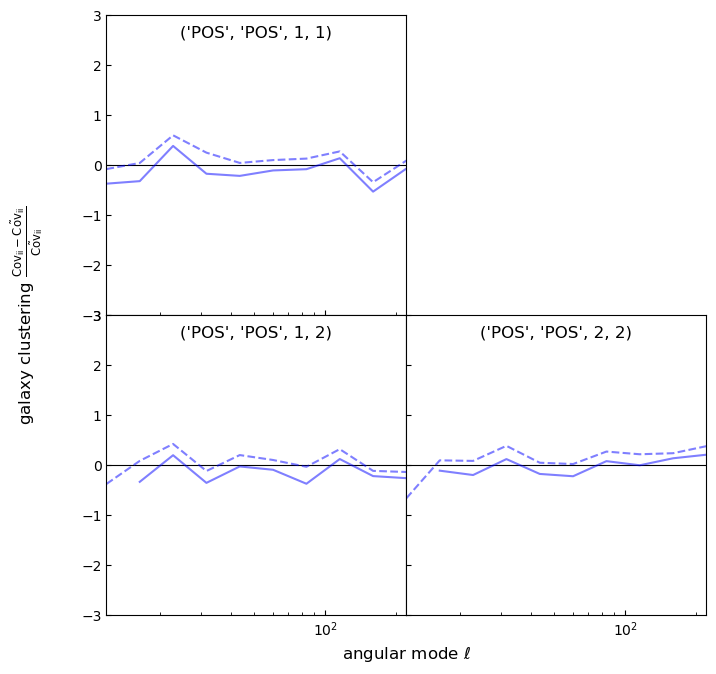

In [29]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("POS", "POS", i, j)
        kk = ("POS", "POS",  "POS", "POS", i, j, i, j)
        sb_kk = ("POS", "POS",  "POS", "POS", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].__array__()
        dc = dices_cov[kk]
        jkc = covjk[kk]
        ens_err = np.sqrt(np.diag(ensemble_cov[kk]))
        dcerr = np.sqrt(np.diag(dc))
        jkcerr = np.sqrt(np.diag(jkc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/ens_err, 'b--', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)


ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(1, lmax+1)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy clustering $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

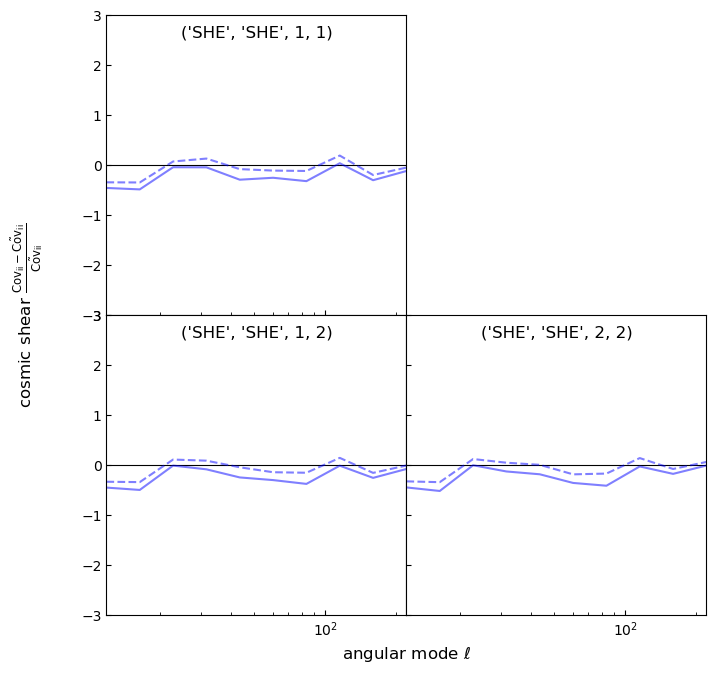

In [30]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        kk = ("SHE", "SHE",  "SHE", "SHE", i, j, i, j)
        sb_kk = ("G_E", "G_E",  "G_E", "G_E", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].array[0, 0, :]
        dc = dices_cov[kk][0, 0, 0, 0, :, :]
        jkc = covjk[kk][0, 0, 0, 0, :, :]
        ens_c = ensemble_cov[kk].array[0, 0, 0, 0, :, :]
        ens_err = np.sqrt(np.diag(ens_c))
        dcerr = np.sqrt(np.diag(dc))
        jkcerr = np.sqrt(np.diag(jkc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/ens_err, 'b--', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)
ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(2, lmax+1 )
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"cosmic shear $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

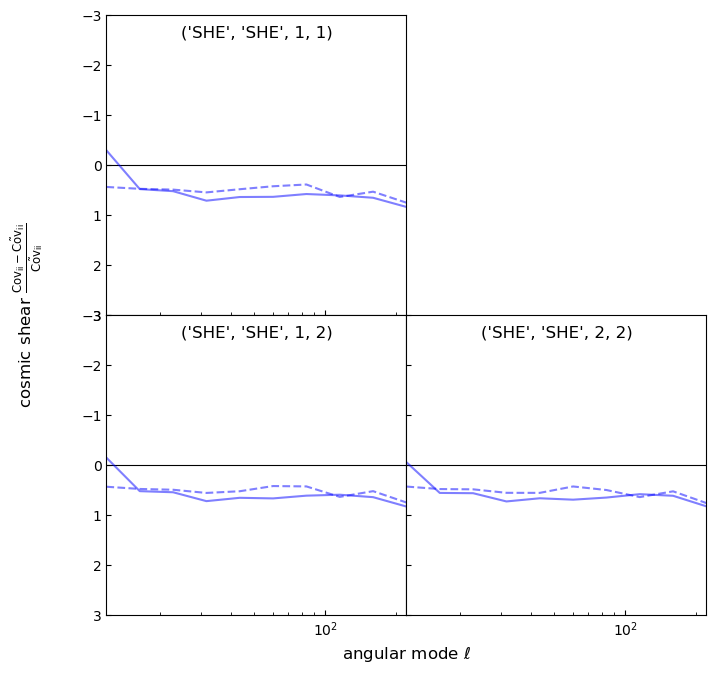

In [34]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, nbins):
        key = ("SHE", "SHE", i, j)
        kk = ("SHE", "SHE",  "SHE", "SHE", i, j, i, j)
        sb_kk = ("G_B", "G_B",  "G_B", "G_B", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].array[1, 1, :]
        dc = np.abs(dices_cov[kk][1, 1, 1, 1, :, :])
        jkc = np.abs(covjk[kk][1, 1, 1, 1, :, :])
        ens_c = ensemble_cov[kk].array[1, 1, 1, 1, :, :]
        ens_err = np.sqrt(np.diag(ens_c))
        jkcerr = np.sqrt(np.diag(jkc))
        dcerr = np.sqrt(np.diag(dc))
        #sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/dcerr, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/jkcerr, 'b--', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        #if i == j:
        #    gc = np.sqrt((2*_vcl**2)/(2*ls+1))
        #    ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)
ax[0, 0].set_xscale("log")
#ax[0, 0].set_yscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(2, lmax+1)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(3, -3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"cosmic shear $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

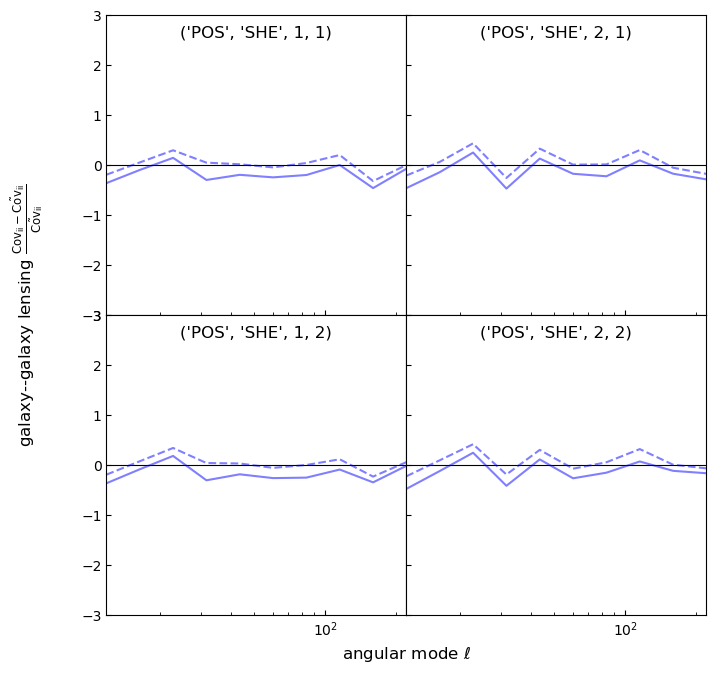

In [32]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "SHE", i, j)
        kk = ("POS", "SHE",  "POS", "SHE", i, j, i, j)
        sb_kk = ("POS", "G_E",  "POS", "G_E", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].array[0, :]
        dc = dices_cov[kk][0, 0, :, :]
        jkc = covjk[kk][0, 0, :, :]
        ens_c = ensemble_cov[kk].array[0, 0, :, :]
        ens_err = np.sqrt(np.diag(ens_c))
        jkcerr = np.sqrt(np.diag(jkc))
        dcerr = np.sqrt(np.diag(dc))
        sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/np.sqrt((np.pi))

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        ax[j - 1, i - 1].plot(ls, (jkcerr-ens_err)/ens_err, 'b--', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        if i == j:
            gc = np.sqrt((2*_vcl**2)/(2*ls+1))
            ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g-', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(ls[0], ls[-1])
else:
    ax[0, 0].set_xlim(2, lmax+1)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(-3, 3)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy--galaxy lensing $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()

In [ ]:
fig, ax = plt.subplots(nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, nbins):
    for j in range(1, nbins):
        key = ("POS", "SHE", i, j)
        kk = kk = ("POS", "SHE",  "POS", "SHE", i, j, i, j)
        sb_kk = ("POS", "G_B",  "POS", "G_B", i-1, j-1, i-1, j-1)
        _vcl = _theory_cls[key].array
        dc = np.abs(dices_cov[kk][0, 1, :, :])
        ens_c = ensemble_cov[key].array[0, 1, :, :]
        ens_err = np.sqrt(np.diag(ens_c))
        dcerr = np.sqrt(np.diag(dc))
        print(dcerr)
        print(ens_err)
        #sberr = np.sqrt(np.diag(sb_cov[sb_kk]))/2

        ax[j - 1, i - 1].plot(ls, (dcerr-ens_err)/ens_err, 'b-', alpha=0.5, label='DICES')
        #ax[j - 1, i - 1].plot(ls, (sberr-ens_err)/ens_err, 'r-', alpha=0.5, label='SpaceBorne')
        #if i == j:
        #    gc = np.sqrt((2*_vcl**2)/(2*ls+1))
        #    ax[j - 1, i - 1].plot(ls, (gc-ens_err)/ens_err, 'g--', alpha=0.5, label='Gaussian')

        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")
        ax[j - 1, i - 1].set_title(key, y=0.9)

ax[0, 0].set_xscale("log")
if binned:
    ax[0, 0].set_xlim(10, lmax * 2)
else:
    ax[0, 0].set_xlim(1 / 3, lmax * 2)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(
    numticks=99, subs=np.arange(0.1, 1.0, 0.1)
)
ax[0, 0].set_ylim(10**2, 10**8)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel(r"galaxy--galaxy lensing $\frac{\rm{Cov}_{ii}-\tilde{\rm{Cov}}_{ii}}{\tilde{\rm{Cov}}_{ii}}$", x=-0.1, ha="right")

plt.show()